Данные: <a href="https://www.kaggle.com/c/bike-sharing-demand">Bike Sharing Demand</a>.


In [1]:
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
df = pd.read_csv('train_bikes.csv')

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Описание набора данных:
Набор данных предоставляет информацию о почасовой аренде велосипедов в течение двух лет в Вашингтоне, округ Колумбия. Для аренды использовались специальные киоски, которые давали возможность случайным прохожим и постоянным клиентам(имеющим регистрацию) взять велосипед на прокат. Данный процесс автоматизирован.

Данные в тренеровочной выборке собраны за 2 года с 1 по 19 число каждого месяца. В конечном счете требуется предсказать спрос на остальные дни месяца.

### Переменные:
- *datatime:* метка времени + дата, к который относится каждый час суток
- *season:* сезон
  1. весна
  2. лето
  3. осень
  4. зима
  
  
- *holiday:* считается ли день праздником. В исходных данных 
  0. нет
  1. да
  
  
- *weather:* погода

  1. ясно, небольшая облачность, частичная облачность
  2. туман + облачность, туман + разорванные облака, туман + небольшая облачность, туман
  3. легкий снег, дождь + гроза + переменная облачность, небольшой дождь + вероятна облачность
  4. сильный дождь + ледяной дождь + гроза + туман, снег + тумат
  
  
- *temp:* температура в градусах Цельсия (показания датчиков)
- *atemp:* "Ощущаемая" температура в градусах Цельсия 
- *humidity:* относительная влажность
- *windspeed:* скорость ветра
- *workingday:* отметка, если день не выходной и не праздник  
- *casual:* количество незарегистрированных пользователей аренды
- *registered:* количество зарегистрированных пользователей аренды
- *count:* общее количество аренды

### Постановка задачи: <br>
Необходимо спрогнозировать спрос на велосипеды (признаки casual, registred, count).

Разработанная модель может помочь выявить наиболее значимые признаки в прогнозировании спроса на прокатные велосипеды разных типов пользователей.

* casual - это незарегестрированные пользователи, которые, возможно, редко пользуются прокатом и им не выгодно оформлять абонемент
* registred - это пользователи, которые завели себе абонемент
* count - registred+casual

Соответственно целевой переменной может быть любое из этих вариантов

Качество оценивается c помощью Root Mean Squared Logarithmic Error (RMSLE) - то есть недопрогноз в данном случае хуже, чем перепрогноз

### Предобработка данных:

Бинарные признаки уже закодированы. <br> 
К категориальным переменным можно применить  One-hot encoding <br>
Можно отдельно выделить признаки для "времени дня", "месяца" и дня недели

In [3]:
def get_date_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['day'] = df.loc[:, 'datetime'].dt.day
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    df['weekday'] = df.loc[:, 'datetime'].dt.weekday
    
    return df

In [4]:
df = df.pipe(get_date_features)


### Первичный анализ признаков:

Основные характеристики переменных и их описание.

#### Вещественные признаки

In [5]:
print(df.shape)
df.describe().T

(10886, 17)


,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


#### Категориальные признаки

In [6]:
for i in ["holiday", "season", "weather", "workingday"]:
    print('')
    print(i)
    print(df[i].value_counts())
    print('_____________________________________________')


holiday
0    10575
1      311
Name: holiday, dtype: int64
_____________________________________________

season
4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
_____________________________________________

weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
_____________________________________________

workingday
1    7412
0    3474
Name: workingday, dtype: int64
_____________________________________________


**Вывод:** <br>
Чаще велосипеды брали в ясную погоду. Присутствует редкая категория "4" в признаке "weather". <br>

#### Анализ линейных зависимостей в данных

Определим, есть ли переменные с высокой корреляцией.

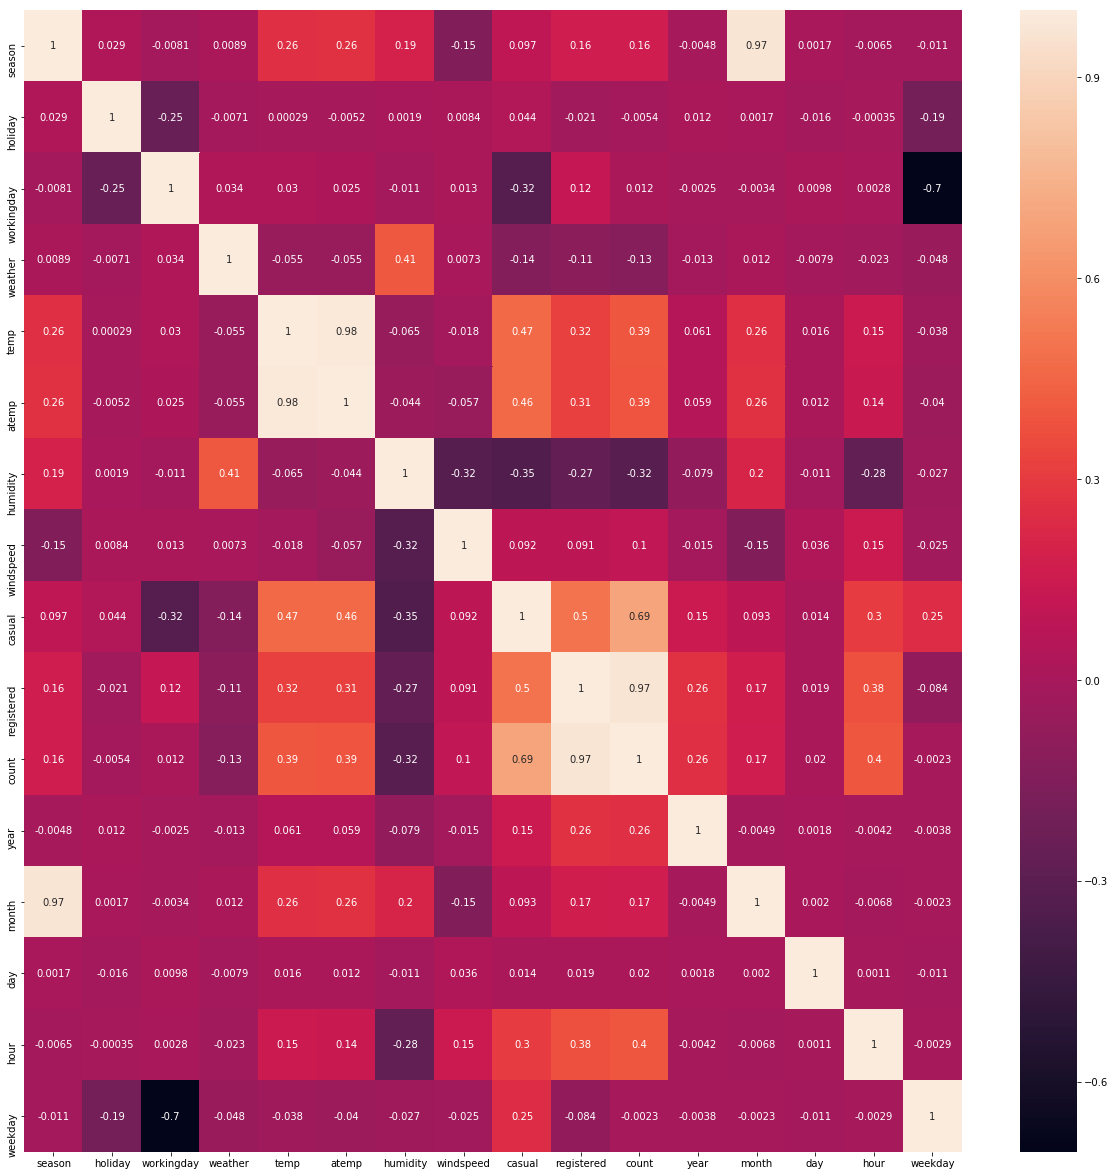

In [7]:
f, ax = plt.subplots(figsize = (21, 21))
sns.heatmap(df.corr(), ax = ax, annot=True)

**Вывод:** <br>
Наибольшую корреляцию имеют atemp и temp. Корреляция близка к 1, поэтому скорее всего придется оставить какую-то одну из переменных.

В то же время, целевые переменные (count, registred и casual) в большей степени коррелированы именно с показтелями температуры

#### Распределение некоторых признаков

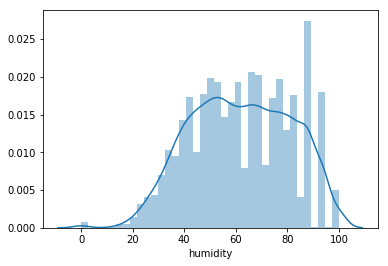

In [8]:
sns.distplot(df['humidity'])

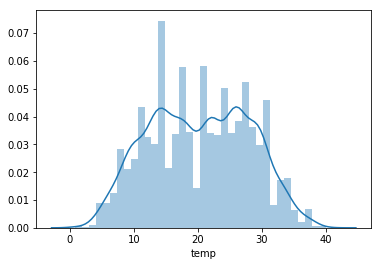

In [9]:
sns.distplot(df['temp'])

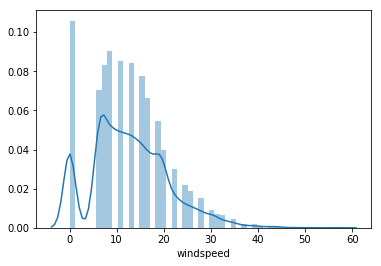

In [10]:
sns.distplot(df['windspeed'])

#### Парные распределения с целевыми признаками

*Выясним, как зависит аренда от даты и времени.*

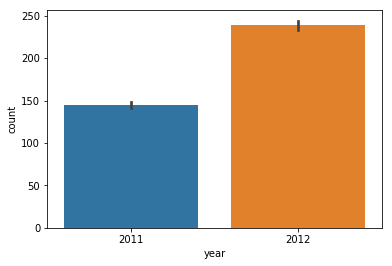

In [11]:
sns.barplot('year', 'count', data=df)

**Вывод:** <br>
Количество аренды возврасло в течение заданного периода (2011 - 2012 года). Стоит это учитывать при прогнозировании на дни соответствующих годов.

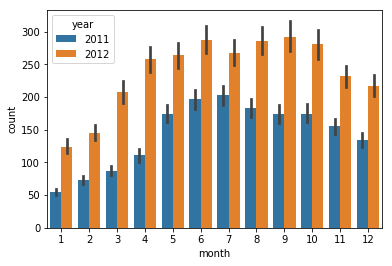

In [12]:
sns.barplot('month', 'count', data=df, hue='year')

**Вывод:** <br>
В зимний период наблюдался спад востребованности велосипедов, а в летние - напротив, рост. То есть прослеживается очевидная сезонность.

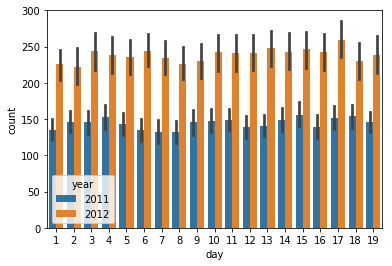

In [13]:
sns.barplot('day', 'count', data=df, hue='year')

**Вывод:** <br>
Можно сделать вывод, что ежедневная востребованность велосипедов в первой половине месяца не имела тенденции резко возрастать или уменьшаться. <br>
То есть данные о дне не имеют высокого влияния на аренду.

/home/dev/.local/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/dev/.local/lib/python3.5/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


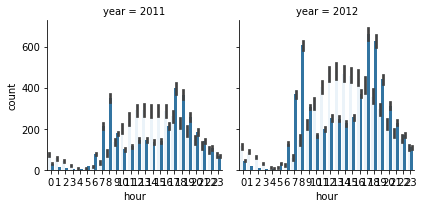

In [14]:
g = sns.FacetGrid(df, col='year')
g.map(sns.barplot, 'hour', 'count', 'workingday')

**Вывод:** <br>
В отличие от дня на календаре время имеет вес в прогнозировании. После возрастания (и последующего падения) в утренние часы, к вечеру количество арендующих постепенно возрастало.

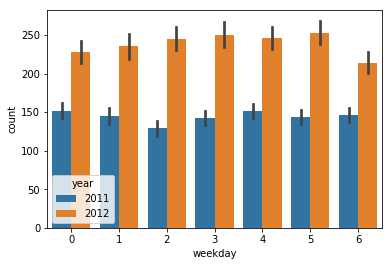

In [15]:
sns.barplot('weekday', 'count', data=df, hue='year')

**Вывод:** <br>
Наблюдался небольшой провал в воскресение.

Посмотрим на отличие в распределение зарегистрированных и незарегистрированных пользователей

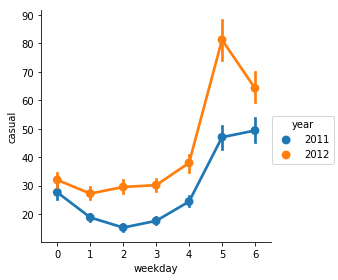

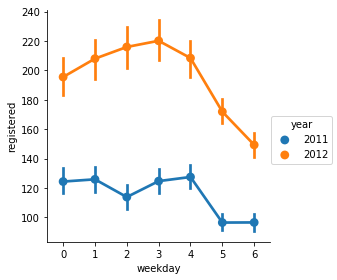

In [16]:
sns.factorplot('weekday', 'casual', data=df, hue='year')
sns.factorplot('weekday', 'registered', data=df, hue='year')

**Вывод: **<br>
Зарегистрированные в системе пользователи чаще брали велосипеды в выходные дни, при этом пик аренды достигался в субботу. <br>
Незарегистированные же предпочитали брать велосипеды в буднии дни, практически игнорируя(в сравнении) при этом выходные дни. Самый низкий показатель датировался воскресением, после чего в понедельник происходил резкий взлёт аренды. <br>

# Getting hands dirty

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

### Задание (0.25)

Создайте переменную (именно отдельную переменную а не стобец в датафрейме) состоящий из строк вида "год-месяц-час"

Эта переменная понадобится нам далее

In [18]:
import datetime
year_month_hour = df[['year','month','hour']].apply(lambda x: '-'.join(x.astype(str)),axis=1)
year_month_hour

0          2011-1-0
1          2011-1-1
2          2011-1-2
3          2011-1-3
4          2011-1-4
5          2011-1-5
6          2011-1-6
7          2011-1-7
8          2011-1-8
9          2011-1-9
10        2011-1-10
11        2011-1-11
12        2011-1-12
13        2011-1-13
14        2011-1-14
15        2011-1-15
16        2011-1-16
17        2011-1-17
18        2011-1-18
19        2011-1-19
20        2011-1-20
21        2011-1-21
22        2011-1-22
23        2011-1-23
24         2011-1-0
25         2011-1-1
26         2011-1-2
27         2011-1-3
28         2011-1-4
29         2011-1-6
            ...    
10856    2012-12-18
10857    2012-12-19
10858    2012-12-20
10859    2012-12-21
10860    2012-12-22
10861    2012-12-23
10862     2012-12-0
10863     2012-12-1
10864     2012-12-2
10865     2012-12-3
10866     2012-12-4
10867     2012-12-5
10868     2012-12-6
10869     2012-12-7
10870     2012-12-8
10871     2012-12-9
10872    2012-12-10
10873    2012-12-11
10874    2012-12-12


### Задание (0.25)

Напишите функцию `prepare_features` которая бы
* Удаляла ненужные признаки (сильно скоррелированные и просто бестолковые, типа `datetime`, `day`)
* Оставляла только один из целевых признаков (casual, registred или count)
* Вместо того, чтобы затачиваться на конкретный час (признак `hour`) создайте новую переменную (утро, день, вечер, ночь). Границы оцените интуитивно. Старую переменную удалите
* Преобразовывала бинарные признаки в вектора с {0,1} а категориальные признаки в вектора с {0,1,...,C-1}
* Опционально: создайте переменную, которая учитывает день недели и время

In [22]:

y_train = df['count']

def prepare_features(df , y ):
    df = df.drop([], axis=1)
    
    df['morning'] = df['hour'].map(lambda x: int(x>6 and x<11))
    df['day']     = df['hour'].map(lambda x: int(x>11 and x<17))
    df['evening'] = df['hour'].map(lambda x: int(x>17 and x<24))
    
    df['temp_cold'] = df['temp'].map(lambda x: int(x>=0 and x<10))
    df['temp_norm'] = df['temp'].map(lambda x: int(x>=10 and x<20)) 
    df['temp_hot'] = df['temp'].map(lambda x: int(x>=20 and x<47))
    
    df = df.drop(['casual','count', 'registered','datetime','day','hour','temp','atemp','datetime','day','humidity','windspeed'], axis=1)
    df = pd.get_dummies(df, columns=['year','month','weather','weekday'])
    return df


 
    


Сделаем не простое разбиение на обучение и контроль а такую, что в контрольной и обучающей выборке будет примерно одинаковое распределение по году-месяцу

In [24]:
X_train = df.pipe(prepare_features, y_train ) 

## Baseline modelling

Для удобства будем использовать не LinearRegression а ElasticNet, так как в нем можно одновременно котроллировать оба типа регуляризации

In [25]:
from sklearn.linear_model import ElasticNet

In [26]:
# alpha - это общая сила регуляризации
# l1_ration - доля, которая приходтися на Lasso регуляризацию. Соответственно остальное идет на Rigde
regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Задание (0.10)

Составьте pipeline, который состоит из следующих этапов (в скобках узакано "название" этапа):

* One-hot encoder ("onehot")
* StandartScaler ("scaler")
* ElasticNet ("elastic")

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [28]:
model = Pipeline([
    #('encoding', OneHotEncoder(categorical_features=[1])), Делал это выше
    ('scaler' , StandardScaler()),
    ('elastic', ElasticNet()), 
]) 

model.fit(X_train, y_train)
 

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

### Задание (0.15)

Перед тем как пойдем дальше реализуем RLMSE

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
 

def rlmse_score(y_test, y_hat): 
        return np.sqrt(((y_test - y_hat) ** 2).mean())
      
# Эту функцию трогать не надо
def rlmse_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    
    return rlmse_score(y, y_hat)

Так как мы еще не знаем, что такое GridSearch или RandomSearch будем исследоать изменение качества только одного из параметров: alpha

Сделаем мы это чуть более хитро чем просто в цикле перебирать разные значения:
* Во-первых мы сделаем особую кросс-валидацию, учитывающую время
* Так как у нас будет кросс-валидация, то мы сможем посмотреть на "стабильность" скора, а не просто на его среднее

In [30]:
from sklearn.model_selection import validation_curve
from  sklearn.datasets  import  make_classification


In [31]:
# Это не обычная кросс-валидация а стратифицированная. №
# С ее помощью мы добъемся того, что в обучающем и валидационном фолде будет одна и та же пропорция годов-месяцев-часов
# Тут то и понадобится нам year_month_hour
# Подробности http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

# Переберем 20 значений в интервале от 10^-3 до 10^5
alpha_range = np.logspace(-3, 5, 20)
 
param_name = "elastic__alpha"
# пишем не просто alpha, потому что у нас pipeline и sklearn должен как-то понимать параметр какого этапа мы перебираем
 
    

train_scores, valid_scores = validation_curve(
    model, 
    X_train, 
    y_train, 
    param_name=param_name, 
    param_range=alpha_range,
    cv=cv.split(X_train, year_month_hour), 
    scoring=rlmse_scorer
)

# На выходе мы получим 2 матрицы размера 20 на n_folds
# Потому что у нас было 5 фолдов и 20 возможных значений гиперпараметра
# А матриц 2, потому что в каждом фолде есть обучающая и валидационная часть


/home/dev/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dev/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dev/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dev/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

### Задание (0.25)

Для каждой матрицы сделайте следующее

* По каждой строчке посчитайте среднее значение (среднее значение качества по заданного значения параметра)
* По каждой строчке посчитайте стандартное отклонение (мера разброса меры качества)

Изобразите график, на котором 
* по оси x отложены значения alpha
* по оси y отложены средние значения меры качества (отдельно для обучающей части и валидационной)
* с помощью функции plt.fill_between изобразите разбос меры качества в каждой точке (придется чутка почитать документации)

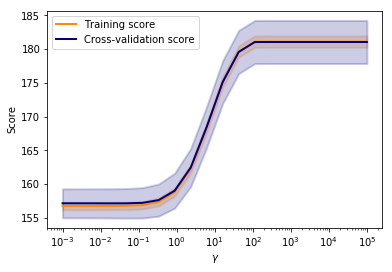

In [74]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
 
plt.xlabel("$\gamma$")
plt.ylabel("Score")
 
lw = 2
plt.semilogx(alpha_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(alpha_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(alpha_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")